In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 read
df_true = pd.read_csv('./data/weather_bicycle_true.csv', parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
df_false = pd.read_csv('./data/weather_bicycle_false.csv', parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
df_true.head()

,날짜,시간,대여개수,대기개수,기온,강수량
0,2021-08-01,2022-08-03 00:00:00,757,24190,24.0,0.1
1,2021-08-01,2022-08-03 01:00:00,747,24200,24.0,0.0
2,2021-08-01,2022-08-03 02:00:00,468,24479,24.0,0.0
3,2021-08-01,2022-08-03 03:00:00,320,24627,24.0,0.0
4,2021-08-01,2022-08-03 04:00:00,256,24691,24.0,0.0


In [3]:
# 전처리
def preprocess(df):
    df['날짜'] = df['날짜'].dt.dayofyear
    df['시간'] = df['시간'].dt.hour
    return df

df_true = preprocess(df_true)
df_false = preprocess(df_false)
df_false.head()

,날짜,시간,대여개수,대기개수,기온,강수량
0,213,0,7156,17791,1.0,0.0
1,213,1,20438,4509,30.0,0.0
2,213,2,1832,23115,26.0,0.0
3,213,3,6543,18404,26.0,0.0
4,213,4,19106,5841,18.0,5.0


In [4]:
input_true = df_true.values
input_false = df_false.values

timesteps = 24
n_features = input_true.shape[1]

In [5]:
# 3차원화
def temporalize(X, timesteps):
	output_X = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
	return np.squeeze(np.array(output_X))

In [6]:
x_true = temporalize(input_true, timesteps)
x_false = temporalize(input_false, timesteps)
print(x_false.shape)

(719, 24, 6)


In [7]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [8]:
scaler = StandardScaler().fit(flatten(x_true))

x_true = scale(x_true, scaler)
x_false = scale(x_false, scaler)

In [9]:
x_train, x_valid = train_test_split(x_true, test_size=0.2)

In [10]:
epochs = 1000
batch = 128
lr = 0.001

In [11]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            4992      
                                                                 
 lstm_1 (LSTM)               (None, 24, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 24, 16)            3136      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 repeat_vector (RepeatVector  (None, 24, 16)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 24, 16)            2112      
                                                        

In [12]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid, x_valid))

Epoch 1/1000
5/5 [==============================] - 6s 261ms/step - loss: 0.9607 - val_loss: 0.9725
Epoch 2/1000
5/5 [==============================] - 0s 54ms/step - loss: 0.9596 - val_loss: 0.9713
Epoch 3/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.9574 - val_loss: 0.9676
Epoch 4/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.9512 - val_loss: 0.9533
Epoch 5/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.9298 - val_loss: 0.9771
Epoch 6/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.9225 - val_loss: 0.9092
Epoch 7/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.8927 - val_loss: 0.8928
Epoch 8/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.8748 - val_loss: 0.8759
Epoch 9/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.8535 - val_loss: 0.8548
Epoch 10/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.8316 - val_loss: 0.8383
Epoch 11

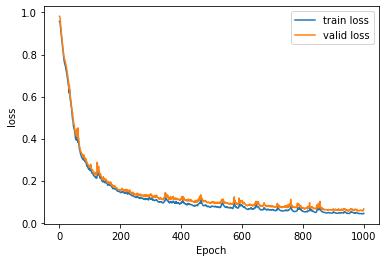

In [25]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

23/23 [==============================] - 0s 8ms/step


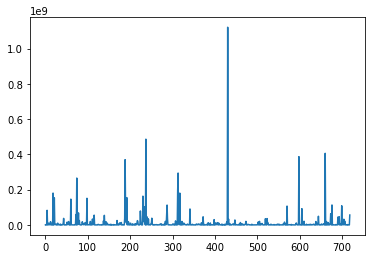

In [44]:
predict_false = lstm_ae.predict(x_false)
mse = np.mean(np.power(flatten(x_false) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse)-1, len(mse)), mse)
# plt.ylim([0, 100])
plt.show()

5/5 [==============================] - 0s 8ms/step


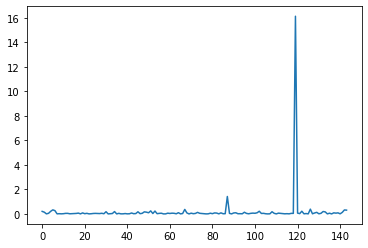

In [41]:
predict_false = lstm_ae.predict(x_valid)
mse = np.mean(np.power(flatten(x_valid) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse)-1, len(mse)), mse)
#plt.ylim([0, 100])
plt.show()

In [43]:
print(x_false.shape)

(719, 24, 6)


In [ ]:
test = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
predict_false = lstm_ae.predict(test)
mse = np.mean(np.power(flatten(x_false) - flatten(predict_false), 2), axis=1)
print(mse)

In [ ]:
predict_false = lstm_ae.predict(x_false)
mse = np.mean(np.power(flatten(x_false) - flatten(predict_false), 2), axis=1)
print(mse)